# Application: Model

## Case study: Houses for sale

In this tutorial, we will build a model with the Python [`scikit-learn`](https://scikit-learn.org/stable/) module. Additionally, you will learn how to create a data preprocessing pipline.

## Setup

In [126]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme(style="ticks", color_codes=True)

# Data preparation

See notebook `10a-application-model-data-exploration.ipynb` for details about data preprocessing and data exploration.

In [127]:
ROOT = "https://raw.githubusercontent.com/kirenz/modern-statistics/main/data/"
DATA = "duke-forest.csv"
df = pd.read_csv(ROOT + DATA)

# Drop irrelevant features
df = df.drop(['url', 'address', 'type'], axis=1)

# Convert data types
df['heating'] = df['heating'].astype("category")
df['cooling'] = df['cooling'].astype("category")
df['parking'] = df['parking'].astype("category")

# drop column with too many missing values
df = df.drop(['hoa'], axis=1)

df.columns.tolist()

['price',
 'bed',
 'bath',
 'area',
 'year_built',
 'heating',
 'cooling',
 'parking',
 'lot']

# Creation of data preprocessing pipeline

In [128]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Data preprocessing pipeline

# for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])

# for categorical features  
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

# Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="category")),
    ('cat', categorical_transformer, selector(dtype_include="category"))
        ])

# Simple regression

In [129]:
# Select features for simple regression
features = ['area']
X = df[features]

X.info()
print("Missing values:",X.isnull().any(axis = 1).sum())

# Create response
y = df["price"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   area    98 non-null     int64
dtypes: int64(1)
memory usage: 912.0 bytes
Missing values: 0


## Data splitting

In [130]:
from sklearn.model_selection import train_test_split

# Train Test Split
# Use random_state to make this notebook's output identical at every run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modeling

In [131]:
from sklearn.linear_model import LinearRegression

# Create pipeline with model
lm_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lm', LinearRegression())
                        ])

In [132]:
# Fit model
lm_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fae88f6eb20>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
          

In [133]:
# Obtain model coefficients
lm_pipe.named_steps['lm'].coef_

array([155120.6689059])

## Evaluation with training data

In [134]:
y_pred = lm_pipe.predict(X_train)

In [135]:
from sklearn.metrics import r2_score

r2_score(y_train, y_pred)  

0.5560009346032928

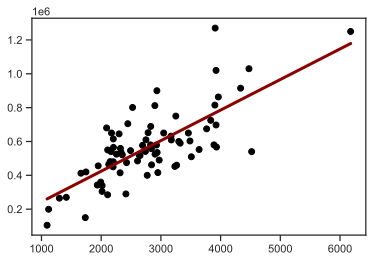

In [136]:
# Plot outputs
plt.scatter(X_train, y_train,  color='black')
plt.plot(X_train, y_pred, color='darkred', linewidth=3);

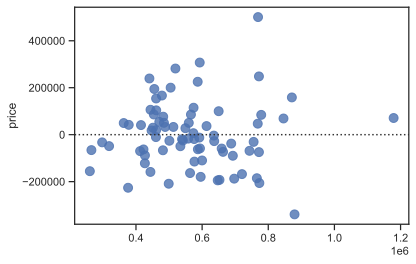

In [137]:
sns.residplot(x=y_pred, y=y_train, scatter_kws={"s": 80});

# Multiple regression

In [138]:
# Select features for multiple regression
features= [
 'bed',
 'bath',
 'area',
 'year_built',
 'cooling',
 'lot'
  ]
X = df[features]

X.info()
print("Missing values:",X.isnull().any(axis = 1).sum())

# Create response
y = df["price"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   bed         98 non-null     int64   
 1   bath        98 non-null     float64 
 2   area        98 non-null     int64   
 3   year_built  98 non-null     int64   
 4   cooling     98 non-null     category
 5   lot         97 non-null     float64 
dtypes: category(1), float64(2), int64(3)
memory usage: 4.2 KB
Missing values: 1


In [139]:
# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [140]:
# Create pipeline with model
lm_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lm', LinearRegression())
                        ])

# Fit model
lm_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fae88f6eb20>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
          

In [141]:
# Obtain model coefficients
lm_pipe.named_steps['lm'].coef_

array([  2447.57967471,  50670.93485383,  86499.75206383,  20145.48540648,
        64856.29369518,  25401.84101108, -25401.84101108])

In [142]:
y_pred = lm_pipe.predict(X_train)

In [143]:
r2_score(y_train, y_pred)

0.693677282935018